## Import Modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib

## Load and Preprocess Data

In [2]:
# Load and preprocess
df = pd.read_csv("fleet_train.csv")
df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df = df.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# --- Load and preprocess test data ---
df_test = pd.read_csv("fleet_monitor_notscored_2.csv")  # <-- Update as needed
df_test["Measurement_timestamp"] = pd.to_datetime(df_test["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df_test = df_test.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# Sensor features
features = [
    "Vehicle_speed_sensor", "Vibration", "Engine_Load", "Engine_Coolant_Temp", "Intake_Manifold_Pressure",
    "Engine_RPM", "Speed_OBD", "Intake_Air_Temp", "Mass_Air_Flow_Rate", "Throttle_Pos_Manifold",
    "Voltage_Control_Module", "Ambient_air_temp", "Accel_Pedal_Pos_D", "Engine_Oil_Temp", "Speed_GPS",
    "Turbo_Boost_And_Vcm_Gauge", "Trip_Distance", "Litres_Per_100km_Inst", "Accel_Ssor_Total",
    "CO2_in_g_per_km_Inst", "Trip_Time_journey"
]

# Normalize
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df_test[features] = scaler.fit_transform(df_test[features])
joblib.dump(scaler, "scaler.save")

['scaler.save']

## Apply SMOTE

In [3]:
# Sequence extraction
SEQUENCE_LENGTH = 10
X_seq, y_seq = [], []

for _, group in df.groupby(["Region", "truckid"]):
    if len(group) < SEQUENCE_LENGTH:
        continue
    X = group[features].values
    y = group["Maintenance_flag"].values
    for i in range(len(X) - SEQUENCE_LENGTH):
        X_seq.append(X[i:i+SEQUENCE_LENGTH])
        y_seq.append(y[i+SEQUENCE_LENGTH])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Flatten for SMOTE
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

# Train-val split before applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_seq_flat, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape back to (batch, sequence, features)
X_train_resampled = X_train_resampled.reshape(-1, SEQUENCE_LENGTH, len(features))

# Convert to tensors and loaders
train_dataset = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32),
                              torch.tensor(y_train_resampled, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.reshape(-1, SEQUENCE_LENGTH, len(features)), dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [4]:
# --- Test Dataset with extra metadata for output ---
class FleetTestDataset(Dataset):
    def __init__(self, df, features, seq_len):
        self.sequences = []
        self.labels = []
        self.meta = []  # to store Region, truckid, timestamp
        for _, group in df.groupby(["Region", "truckid"]):
            if len(group) < seq_len:
                continue
            X = group[features].values
            y = group["Maintenance_flag"].values
            ts = group["Measurement_timestamp"].values
            for i in range(len(X) - seq_len):
                self.sequences.append(X[i:i+seq_len])
                self.labels.append(y[i+seq_len])
                self.meta.append({
                    "Region": group["Region"].iloc[i+seq_len],
                    "truckid": group["truckid"].iloc[i+seq_len],
                    "Measurement_timestamp": str(group["Measurement_timestamp"].iloc[i+seq_len])  # convert to string
                })


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y, self.meta[idx]
    
def custom_collate_fn(batch):
    xs, ys, metas = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys, metas  # metas stays as a list of dicts


test_dataset = FleetTestDataset(df_test, features, SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

## LSTM Model

In [5]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[100, 50], dropout=0.2):
        super().__init__()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_size=input_size, hidden_size=hidden_sizes[0], batch_first=True))
        self.dropout_layers.append(nn.Dropout(dropout))

        for i in range(1, len(hidden_sizes)):
            self.lstm_layers.append(
                nn.LSTM(input_size=hidden_sizes[i-1], hidden_size=hidden_sizes[i], batch_first=True)
            )
            self.dropout_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            x, _ = lstm(x)
            x = dropout(x)

        last_out = x[:, -1, :]
        out = self.fc(last_out)
        return self.sigmoid(out).squeeze()

## Training

In [6]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=len(features), hidden_sizes=[200, 100, 50], dropout=0.3).to(device)
# model.load_state_dict(torch.load("best_model.pt", map_location=device))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping
best_loss = np.inf
patience = 40
trigger_times = 0

In [7]:
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred, y).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model_08-14.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100: 100%|██████████| 1106/1106 [00:05<00:00, 187.31it/s, train_loss=0.821]


Epoch 1: Train Loss = 0.5691, Val Loss = 0.5554


Epoch 2/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.01it/s, train_loss=0.49] 


Epoch 2: Train Loss = 0.4930, Val Loss = 0.4333


Epoch 3/100: 100%|██████████| 1106/1106 [00:06<00:00, 182.10it/s, train_loss=0.372] 


Epoch 3: Train Loss = 0.4144, Val Loss = 0.3543


Epoch 4/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.39it/s, train_loss=0.607] 


Epoch 4: Train Loss = 0.3816, Val Loss = 0.3361


Epoch 5/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.83it/s, train_loss=0.0222]


Epoch 5: Train Loss = 0.3507, Val Loss = 0.3265


Epoch 6/100: 100%|██████████| 1106/1106 [00:05<00:00, 191.79it/s, train_loss=0.113] 


Epoch 6: Train Loss = 0.3255, Val Loss = 0.2996


Epoch 7/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.43it/s, train_loss=0.2]   


Epoch 7: Train Loss = 0.3176, Val Loss = 0.2963


Epoch 8/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.79it/s, train_loss=0.2]   


Epoch 8: Train Loss = 0.3106, Val Loss = 0.3108


Epoch 9/100: 100%|██████████| 1106/1106 [00:05<00:00, 187.86it/s, train_loss=0.079] 


Epoch 9: Train Loss = 0.3077, Val Loss = 0.3802


Epoch 10/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.13it/s, train_loss=0.947] 


Epoch 10: Train Loss = 0.3056, Val Loss = 0.3067


Epoch 11/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.39it/s, train_loss=0.171] 


Epoch 11: Train Loss = 0.3028, Val Loss = 0.2920


Epoch 12/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.96it/s, train_loss=1]     


Epoch 12: Train Loss = 0.2964, Val Loss = 0.3142


Epoch 13/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.34it/s, train_loss=0.1]   


Epoch 13: Train Loss = 0.3021, Val Loss = 0.3197


Epoch 14/100: 100%|██████████| 1106/1106 [00:05<00:00, 191.55it/s, train_loss=1]     


Epoch 14: Train Loss = 0.2965, Val Loss = 0.3290


Epoch 15/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.69it/s, train_loss=0.0895]


Epoch 15: Train Loss = 0.2920, Val Loss = 0.3502


Epoch 16/100: 100%|██████████| 1106/1106 [00:05<00:00, 194.68it/s, train_loss=0.0763]


Epoch 16: Train Loss = 0.2920, Val Loss = 0.3046


Epoch 17/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.87it/s, train_loss=0.717] 


Epoch 17: Train Loss = 0.2914, Val Loss = 0.2982


Epoch 18/100: 100%|██████████| 1106/1106 [00:05<00:00, 194.24it/s, train_loss=0.0722]


Epoch 18: Train Loss = 0.2882, Val Loss = 0.3116


Epoch 19/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.37it/s, train_loss=0.0505]


Epoch 19: Train Loss = 0.2890, Val Loss = 0.3149


Epoch 20/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.61it/s, train_loss=0.000546]


Epoch 20: Train Loss = 0.2888, Val Loss = 0.3196


Epoch 21/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.90it/s, train_loss=0.156] 


Epoch 21: Train Loss = 0.2887, Val Loss = 0.3099


Epoch 22/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.38it/s, train_loss=0.242] 


Epoch 22: Train Loss = 0.2870, Val Loss = 0.2996


Epoch 23/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.16it/s, train_loss=0.11]  


Epoch 23: Train Loss = 0.2849, Val Loss = 0.3084


Epoch 24/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.70it/s, train_loss=1.07]  


Epoch 24: Train Loss = 0.2847, Val Loss = 0.3035


Epoch 25/100: 100%|██████████| 1106/1106 [00:05<00:00, 191.55it/s, train_loss=0.111] 


Epoch 25: Train Loss = 0.2829, Val Loss = 0.3049


Epoch 26/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.25it/s, train_loss=0.000486]


Epoch 26: Train Loss = 0.2816, Val Loss = 0.3002


Epoch 27/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.34it/s, train_loss=0.19]  


Epoch 27: Train Loss = 0.2830, Val Loss = 0.3163


Epoch 28/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.89it/s, train_loss=1.01]  


Epoch 28: Train Loss = 0.2830, Val Loss = 0.3027


Epoch 29/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.70it/s, train_loss=0.0794]


Epoch 29: Train Loss = 0.2785, Val Loss = 0.3078


Epoch 30/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.79it/s, train_loss=0.202] 


Epoch 30: Train Loss = 0.2824, Val Loss = 0.2889


Epoch 31/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.96it/s, train_loss=0.0927] 


Epoch 31: Train Loss = 0.2792, Val Loss = 0.3086


Epoch 32/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.19it/s, train_loss=0.266] 


Epoch 32: Train Loss = 0.2789, Val Loss = 0.2972


Epoch 33/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.28it/s, train_loss=0.0725]


Epoch 33: Train Loss = 0.2760, Val Loss = 0.3067


Epoch 34/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.14it/s, train_loss=0.0746]


Epoch 34: Train Loss = 0.2766, Val Loss = 0.2910


Epoch 35/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.39it/s, train_loss=1.04]   


Epoch 35: Train Loss = 0.2784, Val Loss = 0.2900


Epoch 36/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.03it/s, train_loss=0.855] 


Epoch 36: Train Loss = 0.2745, Val Loss = 0.2831


Epoch 37/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.72it/s, train_loss=0.157] 


Epoch 37: Train Loss = 0.2775, Val Loss = 0.2876


Epoch 38/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.48it/s, train_loss=0.109] 


Epoch 38: Train Loss = 0.2751, Val Loss = 0.2893


Epoch 39/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.88it/s, train_loss=1.1]   


Epoch 39: Train Loss = 0.2737, Val Loss = 0.2989


Epoch 40/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.71it/s, train_loss=0.00106]


Epoch 40: Train Loss = 0.2739, Val Loss = 0.2969


Epoch 41/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.46it/s, train_loss=0.0903] 


Epoch 41: Train Loss = 0.2731, Val Loss = 0.2955


Epoch 42/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.53it/s, train_loss=0.456] 


Epoch 42: Train Loss = 0.2765, Val Loss = 0.2950


Epoch 43/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.50it/s, train_loss=0.151] 


Epoch 43: Train Loss = 0.2713, Val Loss = 0.2898


Epoch 44/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.76it/s, train_loss=0.197]  


Epoch 44: Train Loss = 0.2723, Val Loss = 0.3378


Epoch 45/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.46it/s, train_loss=0.0896]


Epoch 45: Train Loss = 0.2730, Val Loss = 0.3035


Epoch 46/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.13it/s, train_loss=3.03]  


Epoch 46: Train Loss = 0.2727, Val Loss = 0.2889


Epoch 47/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.07it/s, train_loss=0.161]  


Epoch 47: Train Loss = 0.2756, Val Loss = 0.2933


Epoch 48/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.36it/s, train_loss=0.186]   


Epoch 48: Train Loss = 0.2705, Val Loss = 0.3066


Epoch 49/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.77it/s, train_loss=0.151] 


Epoch 49: Train Loss = 0.2703, Val Loss = 0.2933


Epoch 50/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.38it/s, train_loss=0.0722]


Epoch 50: Train Loss = 0.2675, Val Loss = 0.2950


Epoch 51/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.27it/s, train_loss=0.000234]


Epoch 51: Train Loss = 0.2726, Val Loss = 0.2953


Epoch 52/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.41it/s, train_loss=0.96]  


Epoch 52: Train Loss = 0.2700, Val Loss = 0.3001


Epoch 53/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.47it/s, train_loss=0.096] 


Epoch 53: Train Loss = 0.2691, Val Loss = 0.2981


Epoch 54/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.57it/s, train_loss=0.779] 


Epoch 54: Train Loss = 0.2692, Val Loss = 0.3093


Epoch 55/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.01it/s, train_loss=0.114]  


Epoch 55: Train Loss = 0.2692, Val Loss = 0.2947


Epoch 56/100: 100%|██████████| 1106/1106 [00:05<00:00, 194.59it/s, train_loss=0.0941]


Epoch 56: Train Loss = 0.2689, Val Loss = 0.2868


Epoch 57/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.10it/s, train_loss=0.000319]


Epoch 57: Train Loss = 0.2688, Val Loss = 0.2865


Epoch 58/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.12it/s, train_loss=0.0915]


Epoch 58: Train Loss = 0.2694, Val Loss = 0.3057


Epoch 59/100: 100%|██████████| 1106/1106 [00:05<00:00, 194.18it/s, train_loss=0.0652]


Epoch 59: Train Loss = 0.2670, Val Loss = 0.2966


Epoch 60/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.73it/s, train_loss=0.0789]


Epoch 60: Train Loss = 0.2660, Val Loss = 0.2855


Epoch 61/100: 100%|██████████| 1106/1106 [00:05<00:00, 188.66it/s, train_loss=0.000614]


Epoch 61: Train Loss = 0.2665, Val Loss = 0.2895


Epoch 62/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.04it/s, train_loss=0.226] 


Epoch 62: Train Loss = 0.2678, Val Loss = 0.2936


Epoch 63/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.72it/s, train_loss=1.06]  


Epoch 63: Train Loss = 0.2685, Val Loss = 0.2962


Epoch 64/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.65it/s, train_loss=0.0721]


Epoch 64: Train Loss = 0.2668, Val Loss = 0.2973


Epoch 65/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.07it/s, train_loss=0.0582]  


Epoch 65: Train Loss = 0.2668, Val Loss = 0.2978


Epoch 66/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.97it/s, train_loss=0.103]  


Epoch 66: Train Loss = 0.2681, Val Loss = 0.2862


Epoch 67/100: 100%|██████████| 1106/1106 [00:05<00:00, 189.11it/s, train_loss=1.01]  


Epoch 67: Train Loss = 0.2654, Val Loss = 0.3043


Epoch 68/100: 100%|██████████| 1106/1106 [00:05<00:00, 191.47it/s, train_loss=0.893] 


Epoch 68: Train Loss = 0.2662, Val Loss = 0.2983


Epoch 69/100: 100%|██████████| 1106/1106 [00:05<00:00, 193.03it/s, train_loss=0.17]  


Epoch 69: Train Loss = 0.2651, Val Loss = 0.2916


Epoch 70/100: 100%|██████████| 1106/1106 [00:05<00:00, 195.14it/s, train_loss=0.966]  


Epoch 70: Train Loss = 0.2668, Val Loss = 0.3030


Epoch 71/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.59it/s, train_loss=0.0984] 


Epoch 71: Train Loss = 0.2647, Val Loss = 0.3038


Epoch 72/100: 100%|██████████| 1106/1106 [00:05<00:00, 187.82it/s, train_loss=0.158] 


Epoch 72: Train Loss = 0.2654, Val Loss = 0.2880


Epoch 73/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.42it/s, train_loss=0.0728]


Epoch 73: Train Loss = 0.2664, Val Loss = 0.3046


Epoch 74/100: 100%|██████████| 1106/1106 [00:05<00:00, 190.31it/s, train_loss=0.0557]


Epoch 74: Train Loss = 0.2644, Val Loss = 0.2956


Epoch 75/100: 100%|██████████| 1106/1106 [00:05<00:00, 194.21it/s, train_loss=5.1e-5]


Epoch 75: Train Loss = 0.2655, Val Loss = 0.3087


Epoch 76/100: 100%|██████████| 1106/1106 [00:05<00:00, 192.99it/s, train_loss=0.0955]


Epoch 76: Train Loss = 0.2633, Val Loss = 0.3061
Early stopping triggered.


## Testing

   Region       truckid Measurement_timestamp  Maintenance_flag  \
0       1  Truck_0021X1   2016-02-22 16:02:52                 0   
1       1  Truck_0021X1   2016-02-22 16:02:54                 0   
2       1  Truck_0021X1   2016-02-22 16:03:08                 0   
3       1  Truck_0021X1   2016-02-22 16:03:09                 0   
4       1  Truck_0021X1   2016-02-22 16:03:12                 0   

   Prediction_Prob  Prediction_Label  
0         0.000147                 0  
1         0.000149                 0  
2         0.000148                 0  
3         0.000148                 0  
4         0.000152                 0  

Confusion Matrix:
[[1004  151]
 [   8  271]]

Classification Metrics:
  Accuracy:  0.8891
  Precision: 0.6422
  Recall:    0.9713
  F1 Score:  0.7732
  ROC AUC:   0.9353


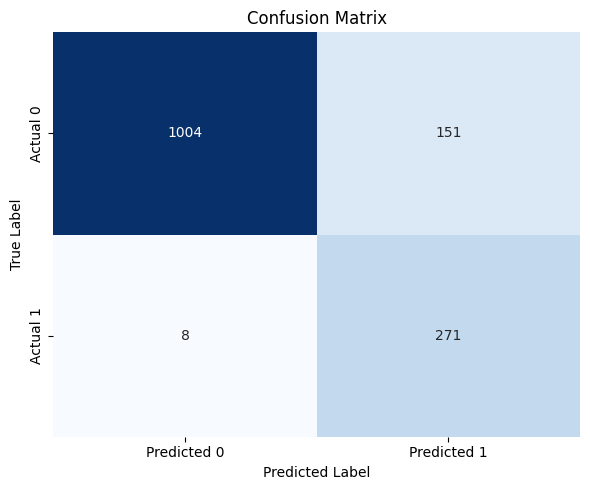

In [9]:
# --- Inference and DataFrame creation ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

threshold = 0.5

results = []
all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch, meta_batch in test_loader:
        X_batch = X_batch.to(device)
        probs = model(X_batch)
        preds = (probs >= 0.5).int()

        for prob, pred, y_true, meta in zip(probs, preds, y_batch.numpy(), meta_batch):
            results.append({
                "Region": meta["Region"],
                "truckid": meta["truckid"],
                "Measurement_timestamp": meta["Measurement_timestamp"],
                "Maintenance_flag": int(y_true),
                "Prediction_Prob": float(prob),
                "Prediction_Label": int(pred)
            })
            all_true.append(int(y_true))
            all_pred.append(int(pred))
            all_probs.append(float(prob))

# --- Create result DataFrame ---
result_df = pd.DataFrame(results)
print(result_df.head())
result_df.to_csv("lstm_test_predictions.csv", index=False)

# --- Compute Metrics ---
conf_matrix = confusion_matrix(all_true, all_pred)
accuracy = accuracy_score(all_true, all_pred)
precision = precision_score(all_true, all_pred, zero_division=0)
recall = recall_score(all_true, all_pred, zero_division=0)
f1 = f1_score(all_true, all_pred, zero_division=0)
try:
    roc_auc = roc_auc_score(all_true, all_probs)
except:
    roc_auc = None

# --- Display Results ---
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
if roc_auc is not None:
    print(f"  ROC AUC:   {roc_auc:.4f}")
else:
    print("  ROC AUC:   Not computable (only one class in y_true)")

import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

# Save the figure
plt.savefig("lstm_confusion_matrix.png")
plt.show()


## Agentic AI

In [15]:
from langgraph.graph import StateGraph, END
from typing import TypedDict
import pandas as pd
import torch
import joblib

# -----------------------------
# Constants & model loading
# -----------------------------
features = [
    "Vehicle_speed_sensor", "Vibration", "Engine_Load", "Engine_Coolant_Temp",
    "Intake_Manifold_Pressure", "Engine_RPM", "Speed_OBD", "Intake_Air_Temp",
    "Mass_Air_Flow_Rate", "Throttle_Pos_Manifold", "Voltage_Control_Module",
    "Ambient_air_temp", "Accel_Pedal_Pos_D", "Engine_Oil_Temp", "Speed_GPS",
    "Turbo_Boost_And_Vcm_Gauge", "Trip_Distance", "Litres_Per_100km_Inst",
    "Accel_Ssor_Total", "CO2_in_g_per_km_Inst", "Trip_Time_journey"
]
SEQUENCE_LENGTH = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=len(features), hidden_sizes=[200, 100, 50], dropout=0.3).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

scaler = joblib.load("scaler.save")

# -----------------------------
# State definition
# -----------------------------
class MaintenanceState(TypedDict):
    fleetid: str
    truckid: str
    region: str
    new_reading: dict
    X_seq: torch.Tensor
    prob: float
    maintenance_needed: bool

# -----------------------------
# Tool 1: Get new reading
# -----------------------------
def get_new_sensor_reading(state: MaintenanceState):
    """
    Simulate getting new sensor readings from the truck.
    """
    state["new_reading"] = {
        "Measurement_timestamp": "22FEB16:17:55:52",
        "Vehicle_speed_sensor": 26,
        "Vibration": 249.689536,
        "Engine_Load": 31.764706,
        "Engine_Coolant_Temp": 87,
        "Intake_Manifold_Pressure": 118,
        "Engine_RPM": 1129,
        "Speed_OBD": 26,
        "Intake_Air_Temp": 17,
        "Mass_Air_Flow_Rate": 19.02,
        "Throttle_Pos_Manifold": 45.09804,
        "Voltage_Control_Module": 14.28,
        "Ambient_air_temp": 6,
        "Accel_Pedal_Pos_D": 14.901961,
        "Engine_Oil_Temp": 83,
        "Speed_GPS": 27.578842,
        "Turbo_Boost_And_Vcm_Gauge": 8.550445794,
        "Trip_Distance": 49.66853177,
        "Litres_Per_100km_Inst": 21.3,
        "Accel_Ssor_Total": 156,
        "CO2_in_g_per_km_Inst": 3.045792,
        "Trip_Time_journey": 289.88788,
        "fleetid": state["fleetid"],
        "truckid": state["truckid"],
        "Region": state["region"]
    }
    return state

# -----------------------------
# Tool 2: Prepare data
# -----------------------------
def prepare_data(state: MaintenanceState):
    """
    Load past data, append the new reading, scale features, and prepare sequence.
    """
    df = pd.read_csv("fleet_monitor_notscored_2.csv")
    df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")

    # Filter historical readings
    df = df[
        (df["fleetid"] == state["fleetid"]) &
        (df["Region"] == state["region"]) &
        (df["truckid"] == state["truckid"])
    ]

    # Append new reading
    new_df = pd.DataFrame([state["new_reading"]])
    new_df["Measurement_timestamp"] = pd.to_datetime(new_df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
    df = pd.concat([df, new_df], ignore_index=True)

    # Sort by timestamp
    df = df.sort_values(by="Measurement_timestamp")

    # Check sequence length
    if len(df) < SEQUENCE_LENGTH:
        raise ValueError(f"Not enough data for truck {state['truckid']} in {state['region']}.")

    # Scale features
    df[features] = scaler.transform(df[features])

    # Prepare sequence for model
    seq_data = df[features].tail(SEQUENCE_LENGTH).values
    state["X_seq"] = torch.tensor(seq_data, dtype=torch.float32).unsqueeze(0).to(device)

    return state

# -----------------------------
# Tool 3: Run prediction
# -----------------------------
def run_prediction(state: MaintenanceState):
    with torch.no_grad():
        prob = model(state["X_seq"]).item()
    state["prob"] = prob
    state["maintenance_needed"] = prob >= 0.5
    return state

# -----------------------------
# Tool 4: Store new reading
# -----------------------------
def store_new_reading(state: MaintenanceState):
    print(f"✅ New reading for truck {state['truckid']} stored in database (simulated).")
    return state



# -----------------------------
# Build LangGraph
# -----------------------------
graph = StateGraph(MaintenanceState)

graph.add_node("get_new_sensor_reading", get_new_sensor_reading)
graph.add_node("prepare_data", prepare_data)
graph.add_node("run_prediction", run_prediction)
graph.add_node("store_new_reading", store_new_reading)

# Define flow
graph.set_entry_point("get_new_sensor_reading")
graph.add_edge("get_new_sensor_reading", "prepare_data")
graph.add_edge("prepare_data", "run_prediction")
graph.add_edge("run_prediction", "store_new_reading")
graph.add_edge("store_new_reading", END)

agent = graph.compile()




In [16]:
# -----------------------------
# Example usage
# -----------------------------
result = agent.invoke({
    "fleetid": "Fleet_00513F1",
    "truckid": "Truck_0051X1",
    "region": 1
})

print(f"Truck {result['truckid']} in region {result['region']}: "
      f"{'Needs Maintenance' if result['maintenance_needed'] else 'OK'} "
      f"(prob={result['prob']:.2f})")

✅ New reading for truck Truck_0051X1 stored in database (simulated).
Truck Truck_0051X1 in region 1: Needs Maintenance (prob=0.82)
